In [192]:
import xxzchain

### dependency

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
#__all__ = ['System','Basis','Operator', 'State']#,'load_system']

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import inspect
from copy import deepcopy
import h5py
import warnings

---

##  Core

In [2]:
from xxzchain import System, Subsystem, Basis, Operator, State

### System

In [ ]:
## In[2]:


class System:
    '''class 'System' is environment Object of Quantum calculation.'''


    def __init__(self, size, name = None, dtype = np.float64):
        '''Please make sure your system's size and symmetry that you want to use.
        Support 1 ~ 32 lattice size.
        You can see the summery of your system through 'System.tree'
        '''
        self.size = size
        self.max = 1<<size
        #self.sample = np.zeros([size],dtype =np.bool)

        #storage
        self.__basis = None
        self._Operator = {}
        self._State = {}
        self._function = {}
        self._Subsystem = {}
        self._fid = 0

        #status for system
        self.__initialized = False
        self.__path = None
        self.__H = None
        self.__symmetry = 'Q' # (spin conserving, traslational sym, parity, spin inversion)

        self.parent = None

        #save/load & Initializer
        self.name = None
        self.saver = Saver(self)
        self.initializer = Initializer(self)
        if name is None:
            self.name = "lattice{}".format(size)

        #Data types
        self.dtype = dtype
        self.Odtype = np.complex128


    ############      tree        ################
    @property
    def tree(self):
        return

    #print summery of system, return is None
    @tree.getter
    def tree(self):
        if not self.__initialized:
            print("System must be initialized. please make sure your path and file with 'initialize(path)'")
        print("Hardcore boson system")
        path = '-----' if self.path is None else os.path.abspath(self.path)
        print("Name         : {}".format(self.name))
        print("Saved path   : {}".format(path))
        print("System size  : {}\n".format(self.size))
        print("Referenced Basis :   (None means full)")
        print('\t|- Sector {} '.format(self.__basis.symmetry))
        print('\t-----\n')

        H = '-----' if self.__H is None else "'{}'".format(self.__H)

        print("Defined Operators :")
        for op in self._Operator:
            print('\t|- {}'.format(op))
        print('\t-----')
        print("\tHamiltonian  : {}\n".format(H))
        print("Defined States :")
        for st in self._State:
            print('\t|- {}'.format(st))
        print('\t-----\n')


    @property
    def path(self): return self.__path
    @path.getter
    def path(self): return self.__path

    #for safety, didn't implement path.setter.

    def set_path(self, path):
        if self.__path is None:
            self.__path = path
        else:
            print("System.path cannot be modified.")

    #####################   symmetry  ##################

    @property
    def symmetry(self):
        return self.__symmetry

    @symmetry.getter
    def symmetry(self):
        print("Current symmetry : ")
        if self.__symmetry[0]:
            print("\t|- Spin conserving : Q")
        if self.__symmetry[1]:
            print("\t|- Translational symmetry : K")
        if self.__symmetry[3]:
            print("\t|- Parity symmetry : P")
        if self.__symmetry[2]:
            print("\t|- Spin inversion symmetry : F")
        if not(self.__symmetry[0] or self.__symmetry[1] or self.__symmetry[2] or self.__symmetry[3]):
            print("\t|- No symmetry applied")
        print("\t---")

    '''@symmetry.setter
    def symmetry(self, value):
        def commute(self):
            if self.__symmetry[0] and self.__symmetry[3]:
                warnings.warn("Spin number conserving and Spin inversion dosen't commute.")
            elif self.__symmetry[1] and self.__symmetry[2]:
                warnings.warn("Translation and Parity dosen't commute.")
            return
        if self.__initialized:
            print("System already initialized.")
        else:
            if type(value) == str:

                if not ( value[0] == '+' or value[0] =='-'):
                    temp = np.array([False,False,False,False])
                    for i in value:
                        ch = 'QKPF'.find(i.upper())
                        if not ch<0:
                            temp[ch] = True
                        else:
                            raise KeyError("Unknown property : {}".format(i))
                    self.__symmetry = temp
                    self.symmetry
                    return commute(self)
                else:
                    temp = self.__symmetry.copy()
                    sign = value[0]
                    value = value[1:]
                    while value:
                        ch = 'QKPF'.find(value[0].upper())
                        if not ch<0:
                            if sign == "+":
                                temp[ch] = True
                                value = value[1:]
                            else:
                                temp[ch] = False
                                value = value[1:]
                        elif value[0] == '+' or value[0] =='-':
                            sign = value[0]
                            value = value[1:]
                        else:
                            raise KeyError("Unknown property : {}".format(value[0]))

                    self.__symmetry = temp
                    self.symmetry
                    return commute(self)
            elif len(value) == 4:
                temp = np.array(value).astype(np.bool)
                self.__symmetry = temp
                self.symmetry
                return commute(self)
            else:
                raise ValueError("Can't set symmetry. Please read doc of symmetry")'''



    ###############################################################################################

    ############# Hamiltonian     ##############
    @property
    def Hamiltonian(self):
        return self.__H
    @Hamiltonian.setter
    def Hamiltonian(self, name):
        if name is None:
            self.__H = None
            return
        for op in self._Operator:
            if op == name:
                self.__H = name
                return
            elif self._Operator[op] == name:
                self.__H = op
                return
        if type(name) == Operator:
            name.set_name('Hamiltonian')
            self.__H = 'Hamiltonian'
            return
        print("Cannot find Operator ({})".format(name))
        return
    @Hamiltonian.getter
    def Hamiltonian(self):
        return self._Operator.get(self.__H, None)




    ############# initializer  ###############           will be modified
    def initialize(self, path = None, force = False):
        '''this method calculate of whole sector by given method.
        every progress will be saved on path you set.
        -->  calculate basis sector on spin number conserved basis sector.
        other sector will be calculated when user call that basis sector.'''
        if path is None:
            if self.path is None:
                print("no preset path detected. system path set as {}".format(self.name))
                self.__path = self.name
                path = self.path
            else:
                path = self.path
        else:
            if self.path is None:
                self.__path  = path
        if not self.__path[-1] =='/':
            self.__path = path+'/'



            #f.attrs['symmetry_order'] = self.name

            #no more need below
            #del self.__state, self.__address, self.__counts, self.__period, self._Qstate, self._Qaddress, self._Qcounts
            #self.__state, self.__address, self.__counts, self.__period, self._Qstate, self._Qaddress, self._Qcounts = [None for _ in range(7)]


            print('Current system saved at "{}"'.format(path))


        if self.__initialized:
            if not force:
                print("System already initialized!")
                return
            else:
                y = input("Previous progress will be lost. Continue?[Y/n] : ")
                if len(y) == 0 or not y.upper()[0] =='Y':
                    print('Initializing canceled.')
                    return
        else:
            if self.saver.isfile() and not force:
                y = ''
                while len(y)==0:
                    y = input("Previous save data exist. Will you load that data?[Y/n] : ")
                if y.upper()[0]=='Y':
                    if not path[-1] == '/': path+='/'
                    return self.load(path+self.name+'.hdf5')
                else:
                    print("Please make other path for save. Or use keyword 'force = True'.")
                    return

        os.makedirs(path,exist_ok=True)

        if (not os.path.isfile(path+self.name+'.hdf5')) or force:  ##########save initializing only for first

            self.saver.attrs['name'] = self.name.encode()
            self.saver.attrs['size'] = self.size

            self.saver.attrs['H'] = str(self.__H).encode()

        self.save()
        self.__initialized = True
        ## construct full sector
        basis  = self.get_full_sector()

        ## find basis sector by given symmetry
        #self.initializer.Q(basis)
        del basis

        self.tree
        return


    ############## system ################
    def valid(self):
        return self.__initialized

    def validation(func):
        def caution(*arg, **kwargs):
            if not arg[0].valid():
                return print("Current system is empty or currupted. Please initialize or load first.")
            return func(*arg, **kwargs)
        return caution

    '''
    def set_name(self, name):
        self.name = name
    '''

    ####################### save ###################
    def save(self):
        '''this method save your system into given path.
        it will contain operator and state.'''
            #self.checkfiles = path+'checkfiles'
            ########check files
        for op in self._Operator:
            self._Operator[op].save()
        self.saver.attrs['H'] = str(self.__H).encode()
        .# -*- coding: utf-8 -*-
        for st in self._State:
            self._State[st].save()
        for sub in self._Subsystem:
            self._Subsystem[sub].save()

        self.saver.flush()

    def delete(self):
        '''this method delete your system that has been saved.
        PLEASE TAKE CARE FOR USING THIS METHOD.'''
        y = input("System will be removed on disk. Continue?[Y/n] : ")
        if len(y)==0 or not y.upper()=='Y':
            print("Delete cancelled")
            return

        os.remove(self.path+self.name+'.hdf5')

        self.__init__(size = self.size)
        print("Done")
        return

    def __del__(self):
        target = list(vars(self).keys())
        for var in target:
            del vars(self)[var]
        return

    def load(self, path):
        '''Please indicate system saved folder. return is system object.
        Recommended way is use of 'load_system(path)'  '''

        ########check files
        self.saver.open(path)
        slash = 0
        while path.find('/',slash+1) >0:
            slash = path.find('/',slash+1)
        self.__path = path[:slash+1]
        self.__initialized=True
        ##########load system
        self.size = self.saver.attrs['size']
        self.name = self.saver.attrs['name'].decode()
        self.__basis = self.get_full_sector()
        fn_ = self.saver.get('function', None)
        op_ = self.saver.get('operator',None)
        st_ = self.saver.get('state',None)
        if not fn_ is None:
            for fn in fn_:
                code = fn_[fn].attrs['code'].decode()
                vect = 'import numpy as np\n@np.vectorize\n'+code
                compiled = compile(vect, 'userfunction','exec')
                exec(compiled, self._function)
                del self._function['np'],self._function['__builtins__']
                if self._fid<fn_[fn].attrs['fid']:
                    self._fid = fn_[fn].attrs['fid']

        if not op_ is None:
            for op in op_:
                self._Operator[op] = Operator.load(self, op)
        if not st_ is None:
            for st in st_:
                self._State[st] = State.load(self, st)

        H = self.saver.attrs['H'].decode()
        if not H == 'None' and self._Operator.get(H, False):
            self.Hamiltonian = H

        print('Current system loaded by "{}"'.format(os.path.abspath(path)))
        self.tree



    ################# basis ################
    def get_full_sector(self):
        '''Access full sector of this system.'''
        basis = Basis(self)
        state = np.arange(self.max)
        address = state
        counts = self.max
        basis.set_basis(state, address,1<<self.size)
        self.__basis = basis
        return basis

    def get_current_basis(self):
        '''return last referenced basis'''
        if self.__basis:
            return self.__basis
        else:
            raise ValueError("There is no basis referenced.")

    #@validation
    def get_basis(self, *arg, **kwarg):
        '''access to specific basis. return is basis object.
        if cannot find sector, then system will calculate.
        positional argument : eigenvalues in order of (Q, K, F, P)
        keywork argument    : Q = q, K = k, F = f, P = p'''
        if len(arg)>4 or len(kwarg)>4: raise KeyError("argument number is allowed only under 4.")
        null = (-1,-1,0,0)
        symbol = 'QKFP'
        ### Follow symmetry order QKFP and make symmetry tuple
        if len(kwarg)==0 and len(arg) == 0:
            return self.get_full_sector()
        if len(arg) == 1 and arg[0] == -1:
            return self.get_current_basis()
        if arg and kwarg or len(arg)>4 or len(kwarg)>4:
            raise KeyError("Too many values are given")
        if arg == null:
            return self.get_full_sector()
        if arg:
            symmetry = arg + null[len(arg):]
        elif kwarg:
            symmetry = list(null)
            for i in kwarg:
                ch = symbol.find(i.upper())
                if ch>=0:
                    symmetry[ch]  = kwarg[i]
                else:
                    raise AttributeError("Symmetry has no property : {}".format(i))

        #symmetry condtion check
        if symmetry[0]>self.size or symmetry[0]<-1:
            raise IndexError("given Q = {} is out of bounds for current system size {}.".format(symmetry[0],self.size))
        if symmetry[1]>self.size or symmetry[1]<-1:
            raise IndexError("given K = {} is out of bounds for current system size {}.".format(symmetry[1],self.size))
        if symmetry[2]>1 or symmetry[2]<-1:
            raise IndexError("given F = {} is out of bounds for eigenvalue of spin inversion.".format(symmetry[2]))
        if symmetry[3]>1 or symmetry[3]<-1:
            raise IndexError("given P = {} is out of bounds for eigenvalue of parity.".format(symmetry[3]))

        basis = Basis(self, *symmetry)
        if not self.saver.is_exist('basis/({},{},{},{})'.format(*symmetry)):
            self.initializer.calculate(symmetry)
        basis.load(*symmetry)
        self.__basis = basis
        return basis

    ## unused
    #@validation
    #def print_sector(self):
    #    for sector in self.__basis.keys():
    #        print(sector)
    #
    #@validation
    #def get_current_basis(self):
    #    return self.__basis


    def print_spin(self, value):
        '''print spinstate with 0(null site),1(particle site) of give integer format state.'''
        try:
            print("{0:b}".format(value).zfill(self.size))
        except:
            print("Vanishing")

    def get_operator(self, op_name):
        '''Access to operator with operators name.
        before that, the operator name set on system.
        if not, it will occur KeyError.'''
        return self._Operator[op_name]

    def get_function(self, key):
        if isinstance(key, int):
            loader = self.saver['function']
            for function in loader:
                if loader[function].attrs['fid'] == key:
                    return self._function[function]
            raise KeyError(key)
        return self._function[key]

    def get_function_script(self, key):
        loader = self.saver['function']
        if isinstance(key, int):

            for function in loader:
                if loader[function].attrs['fid'] == key:
                    print(loader[function].attrs['code'].decode())
                    return
            raise KeyError(key)
        for function in loader:
            if key == function:
                print(loader[function].attrs['code'].decode())
                return
        raise KeyError(key)


    ##################### no ues ##########################
    def load_operators(self, op_name_list=None, obj = None):
        if op_name_list is None:
            op_name_list = list(self._Operator.keys())
        if obj is None:
            glob = globals()
        else:
            glob = vars(obj)
        for op in op_name_list:
            if glob.get(op, None) is None:
                glob[op] = self._Operator[op]
            else:
                print("'{}' is already defined on global variables".format(op))

    def get_state(self, st_name):
        '''Access to state with given state name.
        before that, the operator name set on system.
        if not, it will occur KeyError.'''
        return self._State[st_name]

    def operator_list(self):
        '''retrun operator name list'''
        return list(self._Operator.keys())

    def State_list(self):
        '''return state name list'''
        return list(self._State.keys())

    def function_list(self):
        return list(self._function.keys())

### Subsystem

In [ ]:
#Subsystem

class Subsystem(System):
    def __init__(self, system, spin_range, name):
        super().__init__(len(spin_range), name = name)
        self.range = spin_range
        self.size = len(self.range)
        self.parent = system

    def initialize(self):
        self.spin_site = np.array([1<<i for i in self.range])
        self.saver.set_file(self.parent.saver.create_group(self.name))
        self.saver.attrs['size'] = self.size
        self.saver.attrs['range'] = self.range
        self.save()

    def load(self):
        raise NotImplementedError('not yet.')

### Basis

In [3]:
# In[3]:


class Basis:
    '''Class 'basis' for Hilbert space sector of system.'''
    def __init__(self, system, Q=None, K=None, F = None, P = None, symmetry = None):
        '''make instance of basis that hold given symmetry'''

        #dependency
        self.system = system
        self.size = system.size


        #property
        if not (symmetry is None):
            if len(symmetry) == 4:
                self.symmetry = np.array(symmetry)
                Qp, Kp,Fp,Pp = self.symmetry
            else:
                raise KeyError("Symmetry is ambiguous. symmetry must have 4 component")
        else:
            Qp = -1 if Q is None else Q
            Kp = -1 if K is None else K
            Pp = 0 if P is None else P
            Fp = 0 if F is None else F
            self.symmetry = np.array([Qp,Kp,Fp,Pp], dtype = np.int8)

        self.Q, self.K, self.F, self.P = self.symmetry
        self.__eigen = False
        self.temp = np.zeros([self.size],dtype = np.int8)
        self.__state, self.__address, self.__period, self.__counts = None,None,None,None
        self.data = None
        self.Pd_bar, self.Fd_bar = None, None

        self.path = "basis/({},{},{},{})".format(Qp,Kp,Pp,Fp)
        self.find = np.vectorize(self._find)
        self.distance = np.vectorize(self.distance)
        self.period = np.vectorize(self._period)
        self.convert = np.vectorize(self.convert)
        self.__state_set = None

        self.__load = False

    def __len__(self):
        return len(self.state)

    def __repr__(self):
        if (self.symmetry==[-1,-1,0,0]).all():
            rep =  "<Full basis of lattice size {}".format(self.size)
        else:
            rep = "<Basis sector of lattice size {} with symmetry factor(Q,K,F,P) = ({},{},{},{})".format(self.system.size, *self.symmetry)

        rep+='>'
        return rep


    ############ System  #################

    def set_basis(self, state,address, counts, period = None):
        self.__state = state
        self.__address = address
        self.__counts = counts
        self.__period = period
        self.__states = np.array(state)


    @property
    def state(self):
        return self.__state

    @state.getter
    def state(self):
        return self.__state
    '''@state.setter
    def state(self, value):
        return'''


    def trace(self, operator, eigen=True):
        '''return Tr{ O } on this sector(s). basically, calculate eigenvalues and
        sum over. '''

        return operator.get_matrix(self)[np.diag_indices(len(self.state))].sum()


    def as_state(self):
        return State(self, np.ones([len(self.state)],dtype = self.system.Odtype))


    def _find(self, state):
        '''retrun address from state'''
        return self.__address.get(state,-1)

    def state_set(self, x):
        if self.__state_set is None:
            state_set = self.data['state_set'][:]
            self.__state_set={item[0]:item[np.logical_not(item == -1)][1:] for item in state_set}
        return self.__state_set.get(x,-1)



    @np.vectorize
    def _tran(x, size):
        if x == -1:
            return -1
        return (x>>(size-1))*((1)-(1<<size))+2*x

    def distance(self, target):
        if self.symmetry[1] == -1:
            raise EnvironmentError("'distance' method only supported for translational eigenbasis")
        return self.__distance[target]

    def _period(self, target):
        return self.__period[target]

    def convert(self, x):
        address = self.find(x)
        coef = 1
        if self.K*2 == self.system.size:
            coef *= -1
        elif self.K>0:
            coef = coef*np.exp(np.pi*2*1j*self.K*self.distance(x)/self.system.size)

        if self.P == -1:
            if self.Pd_bar is None:
                self.Pd_bar = {i:True for i in self.data['Pd_bar'][:]}
            if x in self.Pd_bar:
                coef *=-1
        if self.F == -1:
            if self.Fd_bar is None:
                self.Fd_bar = {i:True for i in self.data['Fd_bar'][:]}
            if x in self.Fd_bar:
                coef *= -1

        if address == -1:
            return -1,0
        return address, coef


    def print_states(self, full_state = False, state_set = False):
        if full_state or len(self.state)<20:
            for i in self.state:
                s = "{:10d} : ".format(i)
                string = ''
                if state_set:
                    for state in self.state_set(i):
                        spin = "{0:b}".format(state)
                        spin = '|'+'0'*(self.system.size - len(spin))+spin+'>, '
                        string+= spin
                else:
                    string +="{0:b}  ".format(i).zfill(self.system.size)
                print(s,string[:-2])
        else:
            for i in self.state[:3]:
                s = "{:10d} :".format(i)
                if state_set:
                    for state in self.state_set(i):
                        spin = "{0:b}".format(state)
                        spin = '|'+'0'*(self.system.size - len(spin))+spin+'>, '
                        string+= spin
                else:
                    string +="{0:b}".format(i).zfill(self.system.size)
                print(s,string[:-2])
            print("...")
            for i in self.state[-3:]:
                if state_set:
                    for state in self.state_set(i):
                        spin = "{0:b}".format(state)
                        spin = '|'+'0'*(self.system.size - len(spin))+spin+'>, '
                        string+= spin
                else:
                    string +="{0:b}  ".format(i).zfill(self.system.size)
                print(s,string[:-2])

    def load(self, Q,K,F,P):
        '''load from hdf5 based on given symmetry factor.'''
        self.data = self.system.saver.get('basis/({},{},{},{})'.format(Q,K,F,P))
        self.__state = self.data['state'][:]
        self.__address = { key:val for key, val in self.data['address'][:]}
        self.__period = self.data['period'][:]
        if not K == -1:
            self.__distance = { key:val for key, val in self.data['distance'][:]}
        self.__counts = self.data.attrs['counts']
        self.__load = True

    def get_path(self):
        return system.path+self.path

NameError: name 'np' is not defined

### Operator

In [ ]:
# In[22]:


class Operator:



    def __init__(self, system, name = None, prefix = None):
        '''Operator defined of specific system. One can define own operator using linear
        algebra. use @ symbol for multiply between operator. and also use numpy functions
        when setting coefficient with function.'''
        #print(identity(x))
        self.system = system
        self.size = system.size
        self.name = None
        if not name is None:
            if not name in system._Operator:
                self.name = name
                system._Operator[name] = self
            else:
                #name = 'Op{}'.format(len(system._op))
                print("same operator name exist. set_name() please.")
        self.__default = True

        if not prefix is None:
            self.acting = prefix
            self.__default = False
            if prefix == Operator.identity or prefix == Operator._table['I']:
                self._label = 'I'
            elif prefix == Operator.annihilation or prefix == Operator._table['A']:
                self._label = 'A'
            elif prefix == Operator.creation or prefix == Operator._table['C']:
                self._label = 'C'
            elif prefix == Operator.hopping or prefix == Operator._table['H']:
                self._label = 'H'
            elif prefix == Operator.n_i or prefix == Operator._table['N']:
                self._label = 'N'
            else:
                for name in self.system._function:
                    if prefix == self.system._function[name]:
                        self._label = 'U'
                        fid = self.system.saver['function/'+name].attrs['fid']
                        if len(str(fid))==1:
                            self._label+='0{}'.format(fid)
                        else:
                            self._label+=str(fid)

        else:
            self.acting = Operator.identity
            self._label = 'I'
        #print(self._label)
        if self._label == '':
            raise KeyError
        self.struct = [self.acting]

        self.__coef = np.ones([1],dtype = self.system.Odtype)
        self.__initial = False
        self.matrix = None
        self.__digonalized = False


    def Null(system):
        temp = Operator(system)
        temp.set_default(False)
        del temp.acting
        temp.struct = []
        temp._set_coef([])
        temp._label = 'O'
        return temp


    def loadlabel(system, label):
        temp = Operator.Null(system)
        #print("target : {}".format(label))
        for term in label.split('+'):
            temp1 = Operator(system)
            for op in term.split('@'):
                if op =='O' or len(op) == 0:continue
                if op[0] in Operator._table:
                    temp2 = Operator(system,prefix = Operator._table[op[0]])
                    if len(op[1:])>=2:
                        index = []
                        for ind in range(int(len(op[1:])/2)):
                            index.append(int(op[1+ind*2:3+ind*2]))
                        temp2 = temp2.index(*index)
                elif op[0] == 'U':
                    temp2 = Operator(system,prefix = system.get_function(int(op[1:])))
                temp1 = temp1@temp2
            temp += temp1
        return temp

    def save(self, force = False):
        if self.name == None:  raise ValueError("This operator has no name. please run 'set_name()' first.")

        saver = self.system.saver.require_group('/operator')
        if self.system.saver.is_exist('/operator/{}'.format(self.name)) and not force:
            temp = saver[self.name][:]
            if (temp == self.__coef).all():
                return
            else:
                saver[self.name] = self.__coef
        else:
            if saver.get(self.name,False):
                saver[self.name] = self.__coef
            else:
                saver.create_dataset(self.name, data = self.__coef)
            saver[self.name].attrs['label'] = self._label.encode()
            saver[self.name].attrs['name'] = self.name.encode()

        '''if os.path.isfile(self.system.path+'operator/'+self.name+'.xxz') and not force:
            temp = np.load(open(path+self.name+'.npy','rb'))
            if (temp == self.__coef).all():
                return
            else:
                np.save(open(path+self.name+'.npy','wb'),self.__coef)
        else:
            with open(path+self.name+'.xxz','w') as f:
                #pickle.dump(self.name,f,pickle.HIGHEST_PROTOCOL)
                f.write(self._label+'\n')
            np.save(open(path+self.name+'.npy','wb'),self.__coef,allow_pickle=True)'''

    def load(system, name):
        if system.saver.is_exist('/operator/{}'.format(name)):
            loader = system.saver['/operator/{}'.format(name)]
            temp = Operator.loadlabel(system, loader.attrs['label'].decode())
            temp._set_name(loader.name[loader.name.find('operator/')+9:])
            temp._set_coef(loader[:])
            return temp
        else:
            raise FileExistsError("Operator save file doesn't exist!")

    def __call__(self, target):
        if isinstance(target, State):
            temp = State(target.basis, (self.get_matrix(target.basis)@target.coef))
            return temp
        elif isinstance(target, np.ndarray):
            return np.array(list(self.acton(target)))



    def set_default(self, bool):
        self.__default = bool

    def is_identity(self):
        return self.__default

    def valid(self):
        return self.system.valid()

    def _set_name(self, name):
        if self.name in self.system._Operator: del self.system._Operator[self.name]
        self.name = name
        self.system._Operator[name] = self

    def set_name(self, name):
        #if name in self.system._op: raise KeyError("name : {}, Already Exist!.".format(name))
        if self.name in self.system._Operator: del self.system._Operator[self.name]
        self.name = name
        self.system._Operator[name] = self


    ############ matrix representation
    def get_matrix(self, basis):
        '''return matrix form of Operator as given basis'''
        if (self.__initial == basis.symmetry).all():
            if  not self.matrix is None: return self.matrix
        ############################# load must be implemented
        states = basis.state
        matsize = len(states)
        dtype = self.system.Odtype
        K = False
        if not basis.K == -1:
            K = True
        matrix = np.zeros([matsize**2],dtype = dtype)
        self.__initial = basis.symmetry
        for i, result in enumerate(self.acton(states)):
            #print(i)
            origin = np.array([st for st in result if not st<0])
            #print("origin : {}".format(origin))
            if len(origin)== 0 : continue

            value = np.array([result[st] for st in result if not st<0])
            target, coef = basis.convert(origin)
            #print("target : {}".format(target))

            mask = np.logical_not(target<0)
            target = target[mask]
            coef = coef[mask]
            value = value[mask]
            period = basis.period(target)
            #print("period : {}".format(period))
            #print("operiod : {}".format(basis.period(i)))
            matrix[target*matsize + i] += coef*value*np.sqrt(period/basis.period(i))


        if not K:
            matrix = matrix.real
        self.matrix = matrix.reshape(matsize,matsize)
        return self.matrix


    def trace(self, basis_set, func = lambda x:x, eigen = True):
        '''return Tr{ f( O ) } on given sector(s). '''
        #eigen can be implemented
        if isinstance(basis_set, Basis):
            basis_set = [basis_set]
        length = 0
        vals = []
        for basis in basis_set:
            val = self.get_eigenvalue(basis)
            vals.append(val)
            length += len(val)
        func = np.vectorize(func)
        trace_val = np.empty([length],dtype = self.system.dtype)
        i = 0
        for val in vals:
            for v in val:
                trace_val[i] = v
                i+=1

        result = func(trace_val)
        #M = result.max()
        #m = result.min()
        #result = result.sort()
        #ratio = np.log10(M/m)
        #ratio /= 10
        return result.sum()




    def expectation(self, state):
        '''return list of <Psi| O |Psi>'''
        l = len(state)
        return (state.dual()@ self.get_matrix(state.basis) @state.coef)[np.diag_indices(l)]

    def act(self, state):
        return self.get_matrix(state.basis) @ state.coef.T

    def solve_on(self, basis):
        if self.name is None:
            print("For Solving eigenvalue problem, Operator must have its own name.")
            return
        self.get_matrix(basis)
        val, vec = np.linalg.eigh(self.matrix)
        saver = self.system.saver['basis/({},{},{},{})'.format(*basis.symmetry)].require_group(self.name)
        saver.create_dataset('eigenvalue',data = val)
        saver.create_dataset('eigenvector',data = vec)


    def get_eigenvalue(self, basis):
        if not basis.data.get(self.name,False):
            print("Initializing.... it may takes few minutes.")
            self.solve_on(basis)
        return basis.data[self.name]['eigenvalue'][:]


    def get_eigenvectors(self, basis):
        '''return matrix of eigenvector of this Operator based on given basis.'''
        if not basis.data.get(self.name,False):
            print("Initializing.... it may takes few minutes.")
            self.solve_on(basis)
        return basis.data[self.name]['eigenvector'][:]

    def get_eigenstates(self, basis):
        return State(basis, self.get_eigenvectors(basis))

    ########## main operation   ##########
    def acton(self, x): #x is array of state
        '''x is array of bitwise state(int type). return is another state(int type). default is Identity
        you can also implement of your own operator with keeping return format'''
        states = []
        for i,op in enumerate(self.struct):
            op = np.vectorize(op)
            states.append((op(x), self.__coef[i]))
        results = []
        for _ in range(len(x)):
            results.append({})

        for st, coef in states:
            for j,s in enumerate(st):
                results[j][s] = results[j].get(s, 0) + coef
        return results




    def __mul__(self, other):
        if isinstance(other, self.__class__):raise OverflowError("Operator cannot be mul, please use @ symbol.")#if type(self)== type(other):
        temp = Operator(self.system)
        temp.set_default(self.__default)
        temp.struct = self.struct
        temp.acting = self.acting
        temp._label = self._label
        if type(other) == type(np.ufunc):
            self.__coef = other(self.__coef)
        else:
            temp._set_coef(self.__coef*other)
        return temp

    def __rmul__(self, other): return self.__mul__(other)

    def __add__(self, other):
        #print("me!")
        if isinstance(other, self.__class__):#if type(other) == type(self): #operator -> make parallel operation (merging)
            if self.__default and other.is_identity():       # dd Identity op -> calculate value sum
                return other.__add__(self.__coef)
            if not self.system == other.system: raise EnvironmentError("Operators cannot add between different system")
            temp = Operator(self.system)
            temp.set_default(False)
            struct = []
            label = ''
            l = len(self.struct)+len(other.struct)
            coef = np.zeros([l],dtype = self.system.Odtype)
            i= 0
            for la, co, op in zip(self._label.split('+'),self.__coef, self.struct):
                coef[i] = co
                struct.append(op)
                label+= la+'+'
                i+=1
            for la, co, op in zip(other._label.split("+"), other.__coef, other.struct):
                coef[i] = co
                struct.append(op)
                label+= la+'+'
                i+=1
            temp._set_coef(coef)
            temp.struct = struct
            temp._label = label[:-1]
            assert len(coef) == len(temp.struct),"{},{}".format(len(coef), len(temp.struct))
            return temp
        elif self.__default: #when self is identity -> calculate value(coefficient)
            temp = Operator(self.system)
            temp._set_coef(self.__coef+other)
            return temp
        else:
            temp = Operator(self.system)
            temp._set_coef(temp.coef*other)
            return self+temp
        raise ValueError("Value operation is only allowed for Identity.")


    @property
    def coef(self):
        return self.__coef

    @coef.getter
    def coef(self):
        return self.__coef

    def _set_coef(self, value):
        self.__coef = value

    def __radd__(self, other):
        #print("1")
        if not type(self) == type(other):
            return self.__add__(other)

    def __iadd__(self, other):
        #print("me!")
        if isinstance(other, self.__class__):#if type(other) == type(self): #operator -> make parallel operation (merging)
            if not self.system == other.system: raise EnvironmentError("Operators cannot add between different system")
            if self.__default and other.is_identity():       #Identity -> calculate value sum
                temp=Operator(self.system)
                temp._set_coef(self.__coef+other.coef)
                return temp
            l = len(self.coef)+len(other.coef)
            coef = np.zeros([l],dtype=self.system.Odtype)
            for i in range(len(self. coef)):
                coef[i] = self.coef[i]
            i = len(self.coef)
            for j in range(len(other.coef)):
                coef[i+j] = other.coef[j]
            label  = self._label
            struct = []
            for op in self.struct:
                struct.append(op)
            for la, op in zip(other._label.split('+'),other.struct):
                label += '+'+la
                struct.append(op)
            if label[0] == 'O':
                label = label[2:]
            temp = Operator(self.system)
            temp._set_coef(coef)
            if len(struct) == 1:
                temp.acting = struct[0]
            temp._label = label
            temp.struct = struct
            return temp
        else:
            self._set_coef(self.__coef+other)
            return self

    def __riadd__(self, other): return self.__iadd__(other)


    def __sub__(self, other):
        return self.__add__(-1*other)



    def __matmul__(self, other):
        #print("me!")
        if isinstance(other, self.__class__):#if type(other) == Operator:
            if not self.system == other.system: raise EnvironmentError("Operators cannot matmul between different system")

            if other.is_identity():
                return self * other.coef
            elif self.__default:
                return other * self.__coef
            temp = Operator(self.system)
            temp.set_default(False)
            struct = []
            label = ''
            l = len(other.struct)
            tl = len(self.struct) * l
            coef = np.zeros([tl],dtype = self.system.Odtype)
            def dec(a,b):
                def wrap(x):
                    return a(b(x))
                return wrap
            for i,val1 in enumerate(zip(self._label.split("+"),self.struct)):
                la1,my_op = val1
                for j,val2 in enumerate(zip(other._label.split("+"),other.struct)):
                    la2, o_op = val2
                    coef[i*l+j] = self.coef[i]*other.coef[j]
                    label += la1+'@'+la2 +'+'
                    struct.append(dec(my_op,o_op))
            temp._label = label[:-1]
            temp._set_coef(coef)
            temp.struct = struct
            return temp
        elif isinstance(other, State):
            if self == self.system.Hamiltonian:
                return self.get_eigenvalue(other.basis)*other.eigencoef
        else:
            raise ValueError("Only Operators matmul allowed.")



    ########## state calculation ##########
    #@np.vectorize                                # I
    def identity(x):
        return x

    #@np.vectorize                                # a
    def annihilation(x, i):
        if x == -1: return -1
        if (x>>i)&1:
            return x^(1<<i)
        return -1

    #@np.vectorize                                # c
    def creation(x, i):
        if x == -1: return -1
        if not (x>>i)&1:
            return x^(1<<i)
        return -1

    #@np.vectorize                                # n
    def n_i(x,i):
        if x == -1: return -1
        if (x>>i)&1:
            return x
        return -1

    #@np.vectorize                                # h
    def hopping(x,i,j):
        if x == -1: return -1
        m = (1<<i)|(1<<j)
        ch = m&x
        if  ch == m  or not ch: return -1
        return x^m


    def index(self, *arg):
        narg = []
        label = ''
        for a in arg:
            narg.append(a%self.system.size)
            label += "{}".format(a%self.system.size).zfill(2)
        temp = Operator(self.system)
        temp.set_default(False)
        temp.acting = lambda x: self.acting(x,*narg)
        temp._label = self._label+label
        temp.struct = [temp.acting]
        return temp



    b_i = annihilation
    b_i_dag = creation

    _table = {'A':annihilation, 'C': creation, 'I' : identity, 'H':hopping, 'N':n_i}

### State

In [ ]:
# In[23]:


class State:
    path = '/state/'
    def __init__(self, basis, coef, name = None):
        '''state information get by basis, and this instance only contain its coefficient as vector ( shape of (,length) )'''
        self.system = basis.system
        self.basis = basis
        self.states = basis.state
        self.__coef,self.__eigencoef = None,None
        self.coef  = coef.copy()
        self.time = 0
        self.length = len(self.coef)
        self.times = []
        self.name = None
        if name is not None:
            self.set_name(name)
        if self.system.Hamiltonian is not None:
            self.__eigencoef = self.system.Hamiltonian.get_eigenvectors(basis)@self.__coef
        #assert len(coef) == len(basis.state)

    @property
    def coef(self):
        return self.__coef

    @coef.setter
    def coef(self, coef):
        self.__coef = coef.astype(np.complex128)
        if self.__coef.shape[0] == len(self.basis) and not self.__coef.shape[1] == len(self.basis):
            self.__coef = self.__coef.T

        if self.system.Hamiltonian is not None:
            self.__eigencoef = self.system.Hamiltonian.get_eigenvectors(self.basis)@self.__coef
        return

    @coef.getter
    def coef(self):
        return self.__coef

    @property
    def eigencoef(self):
        return self.__eigencoef

    @eigencoef.setter
    def eigencoef(self, coef):
        if self.system.Hamiltonian is None:
            raise EnvironmentError("Hamiltonian is None.")
        if coef.shape[0] == len(self.basis.state):
            self.__eigencoef = coef.T
        elif coef.shape[1] == len(self.basis.state):
            self.__eigencoef = coef
        else:
            raise ValueError("coefficient must be same")
        self.__coef = self.system.Hamiltonian.get_eigenvectors(self.basis).T@self.__eigencoef
        return
    @eigencoef.getter
    def eigencoef(self):
        if self.system.Hamiltonian is None:
            raise EnvironmentError("Hamiltonian is None.")
        if self.__eigencoef is None:
            self.__eigencoef = self.system.Hamiltonian.get_eigenvectors(self.basis)@self.__coef
        return self.__eigencoef

    def norm(self):
        return np.linalg.norm(self.coef)

    def __len__(self):
        return self.length

    def __getitem__(self, key):
        return self.__coef.T[key].T

    def set_name(self, name):
        if name in self.system._State: raise KeyError("'{}' is already exist!".format(name))
        if self.name is not None and self.name in self.system._State: del self.system._State[self.name]
        self.system._State[name] = self
        self.name  = name
        self.path = 'state/{}/'.format(self.name)

    def save(self, force = False):
        if self.name is None:
            raise NameError("This state has no name.")
        saver = self.system.saver[self.path].require_group(self.name)
        saver.attrs['basis'] = self.basis.symmetry
        saver.attrs['name'] = self.name
        if saver.get('coef',None) is None:
            saver.create_dataset('coef',data = self.__coef, compression = 'lzf')


    def load(system, name, force=None):
        loader = system.saver.get('state/'+name,None)
        if loader is None:
            print("'{}' State doesn't exist!".format(name))
            return
        symmetry = loader.attrs['basis']
        coef = loader['coef'][:]
        temp = State(system.get_basis(*symmetry),coef.T, name)
        return temp

    def dual(self):
        return self.coef.conjugate().T

    def stack(states):
        chenv = True
        length = 0
        basis = states[0].basis
        for state in states:
            chenv = chenv and state.basis == basis
            length += len(state)
        coef = np.zeros([length, len(basis.state)],dtype = states[0].system.dtype)
        for i, state in enumerate(states):
            coef[i] = state.coef.T
        return State(basis, coef)


    def __repr__(self):
        rep = ''
        rep += "'{}' state on sector {}\n".format(self.name, (self.basis.Q,self.basis.K))
        time = '0     (initial)' if self.time ==0 else self.time
        rep += "t             : {}\n".format(self.time)
        rep += 'State         : {}\n'.format(self.coef)
        if self.__eigencoef is not None:
            rep += '(eigen State) : {}\n'.format(self.eigencoef)
        return rep


    def time_evolving(self, t):
        if not os.path.isdir(self.path):
            self.save()
        '''return is |Psi(t)> '''
        if self.system.Hamiltonian is None:
            print("Hamiltonian is not defined. please define Hamiltonian of system.")
            return self
        H = self.system.Hamiltonian
        if self.time == 0:
            self.__eigencoef = H.get_eigenvectors(self.basis)@self.__coef
        self.time = t
        if t in self.times:
            return self.loadt(t)
        self.times.append(t)
        self.__eigencoef *= np.exp(-1j*H.get_eigenvalue(self.basis)*t)
        self.__coef = H.get_eigenvectors(self.basis).T@self.eigencoef
        np.save(open(self.system.path+self.path+'t={}.st'.format(t),'wb'),self.coef,allow_pickle=True)
        np.save(open(self.system.path+self.path+'t={}.es'.format(t),'wb'),self.eigencoef,allow_pickle=True)
        return self

    def loadt(self, t):
        if not t in self.times: self.time_evolving(t)
        self.time = t
        self.coef = np.load(open(self.system.path+self.path+'t={}.st'.format(t)))
        self.eigencoef = np.load(open(self.system.path+self.path+'t={}.es'.format(t)))
        return self


    def normalize(self, value = 1):
        self.coef *= value/np.linalg.norm(self.coef)


    def __add__(self, other):
        if not isinstance(other, self.__class__): raise ValueError("State only can be added with state.")
        if not self.basis == other.basis: raise EnvironmentError("Adding between different basis is not allowed")
        if len(self)  == 1:
            return other + self
        return State(self.basis, self.coef.T+other.coef.T)

    def __sub__(self, other):
        return self + -1*other

    def __mul__(self, other):
        return State(self.basis, self.coef.T*other)

    def __matmul__(self, other):
        if isinstance(other, self.__class__):
            raise TypeError("matmul between states is not supported yet.")
        else:#if isinstance(other, Operator):
            raise SyntaxError("Did you mean State.T @ Operator?")




    def __rmatmul__(self, other):
        if isinstance(other, Operator):
            return State(self.basis, (other.get_matrix(self.basis)@self.coef).T)


    def print_states(self, full_state = False, state_set = False):
        return self.basis.print_states(full_state, state_set)

### Saver

In [ ]:
class Saver:
    def __init__(self,system):
        self.system = system
        self.__file = None
        self.__IO = None

    def open(self, path = None):
        '''create new hdf5 format data. if exist, open hdf5 '''
        if not self.__file is None:
            return
        if path is None:
            self.__file = h5py.File(self.system.path+self.system.name+'.hdf5','r+')
        else:
            self.__file = h5py.File(path, 'r+')

    def close(self):
        #del self.__file
        if not self.__file is None:
            self.__file.close()
            self.__file = None

    def set_file(self, h5obj):
        self.__file = h5obj

    def __del__(self):
        del self.__file


    def _create(self):
        #del self.__file
        self.__file = h5py.File(self.system.path+self.system.name+'.hdf5','a')
        self.__file.clear()
        #self.file.create_group('Workspace')

    def isfile(self, path = None):
        if path is None:
            return os.path.isfile(self.system.path+self.system.name+'.hdf5')
        else:
            return os.path.isfile(path)

    def is_exist(self, target_path):
        '''return True when Data exist on given path.'''
        ch  = not (self.file.get(target_path, None) is None)
        return ch

    def ls(self, path = None, tapping = '', show_all = False):
        if path is None:
            target = self.__file
            print(self.file.filename)
        else:
            target = self[path]
            print(tapping+target.name+" : dir")
        tapping += '\t'
        for name, item in list(target.items()):
            if isinstance(item, h5py.Group):
                if show_all:
                    self.ls(item.name, tapping, show_all)
                else:
                    print(tapping+item.name+" : dir")
            else:
                print(tapping+name)
    @property
    def file(self):
        return
    @file.getter
    def file(self):
        if self.__file is None:
            self.open()
        return self.__file
    @property
    def attrs(self):  return self.open()
    @attrs.getter
    def attrs(self):
        return self.file.attrs
    def require_group(self, *arg,**kwarg): return self.file.require_group(*arg,**kwarg)
    def get(self, *arg,**kwarg): return self.file.get(*arg,**kwarg)
    def flush(self):          return self.file.flush()
    def items(self):          return self.file.items()
    def keys(self):           return self.file.keys()
    def values(self):         return self.file.values()
    def __getitem__(self, key):         return self.file[key]
    def __setitem__(self, key, value):
        if self.is_exist(key):
            self.file[key] = value
        else:
            self.files.attrs[key] = value

### Initializer

In [ ]:
class Initializer:
    '''Basis sector calculator/'''
    comb = lambda self,q: int(math.factorial(self.size)/math.factorial(q)/math.factorial(self.size-q)) #nCq

    ## to check for 8-digits counting number of 1 table
    Qlist = [0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4,
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
            4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8]     # set of 8 bit

    #translate 1110 => 1101 with size 4, translate state left side
    _translate = lambda self, n: (n>>(self.system.size-1))*((1)-(1<<self.system.size))+2*n
    #reverse translate 1110 => 0111 with size4, translate state right side
    _rtranslate = lambda self, n: ((n&1)<<self.system.size-1) + (n>>1)



    #spinz = lambda self, x,i: (x>>i)&1 # return 0, 1
    def parity(self, x):
        p=0
        for i in range(self.__l):
            p = p<<16
            p+= self.Plist[((1<<16)-1)&(x>>16*i)]
        p = p<<self.__r
        p += self.Plist[((1<<16)-1)&(x>>16*self.__l)]>>(16-self.__r)
        return p
    par_num = lambda self, x: self.Qlist[x&255]+self.Qlist[(x>>8)&255]+self.Qlist[(x>>16)&255]+self.Qlist[(x>>24)&255]
    @np.vectorize
    def _npar_num(x):
        return Initializer.Qlist[x&255]+Initializer.Qlist[(x>>8)&255]+Initializer.Qlist[(x>>16)&255]+Initializer.Qlist[(x>>24)&255]

    @np.vectorize
    def _ncheck(x, size):
        '''function to check whether given state is smallest state
        based on translational symmetry or not.
        return is period(positive integer), or error(-1)'''
        tr = lambda a, size:(a>>(size-1))*((1)-(1<<size))+2*a
        origin = x
        for i in range(size):
            a = tr(x,size)
            if a <origin:
                return -1
            elif a == origin:
                break
            x = a
        return i+1



    def __init__(self, system):
        '''Just need system,
        many method will take basis sector and give split sectors of them.'''
        self.system = system
        self.translate = np.vectorize(self._rtranslate)
        self.null = (-1,-1,0,0)
        self.init = [self.Q, self.K, self.F,self.P]
        self.Plist = []
        self.__l, self.__r = int((self.system.size)/16), self.system.size%16
        for i in range(1<<16):
            p = 0
            for j in range(16):
                p+= ((i>>j)&1)<<(15-j)
            self.Plist.append(p)
        self.parity = np.vectorize(self.parity)

    def calculate(self, symmetry):
        symmetry =tuple(symmetry)
        for i in range(4):
            test = symmetry[:i+1] + self.null[i+1:]
            if test == self.null: continue
            if not self.system.saver.is_exist('/basis/({},{},{},{})'.format(*test)):
                self.init[i](self.system.get_basis(*(symmetry[:i] + self.null[i:])))

        '''if not self.system.saver.is_exist('/basis/({},{},{},{})'.format(symmetry[0], *self.null[1:])):
            self.Q(self.system.get_full_sector())
        elif not self.system.saver.is_exist('/basis/({},{},{},{})'.format(*symmetry[:2], *self.null[2:])):
            self.K(self.system.get_basis(symmetry[0]))'''
        #elif not self.system.saver.is_exist('/basis/({},{},{},{})'.format(symmetry[:3], *self.null[3:])):


    def Q(self, basis):
        '''Initializer which find all small sector based on spin conservation.'''
        target = basis.state
        symmetry = basis.symmetry.copy()
        if (not symmetry[2]==0):
            raise EnvironmentError("Spin conserving and spin inversion are not commute on given basis.")
        print("Initializing spin conserving sectors of given basis : ({},{},{},{})".format(*symmetry))

        #calculate basis sector
        state, address, period, counts = [],[],[],np.zeros([self.system.size+1],dtype = np.int64)
        for i in range(self.system.size+1):
            state.append([])
            address.append({})
            period.append([])
            counts[i] = 0
        Q = self._npar_num(target)
        if symmetry[1] == -1:
            for q,s in zip(Q,target):
                state[q].append(s)
                address[q][s] = counts[q]
                counts[q]+=1
        else:
            raise SystemError("if this error occur then must debug")

        #save sectors
        bsaver = self.system.saver.file.require_group('/basis')
        for q in range(self.system.size):
            assert len(state[q]) == counts[q], 'component and its label unmatched'
            symmetry[0] = q
            folder = bsaver.require_group('({},{},{},{})'.format(*symmetry))
            folder.create_dataset('state',data = np.array(state[q]),compression = 'lzf')
            folder.create_dataset('address',data = np.array(list(address[q].items())),compression = 'lzf')
            folder.create_dataset('period',data = np.array(period[q]),compression = 'lzf')
            folder.attrs['counts'] = counts[q]






    def K(self, basis):
        '''Initializer which find all small sector based on translational invarient.'''
        #get infomation of target basis
        st = basis.state
        symmetry = basis.symmetry.copy()
        print("Initializing momentum sectors of given basis : ({},{},{},{})".format(*symmetry))
        #make new empty storage
        state, address, period, distance, counts = [],[],[],[],[]# [[] for q in range(self.size+1)],[[] for q in range(self.size+1)],[[] for q in range(self.size+1)],[[] for q in range(self.size+1)]
        states = {}
        for k in range(self.system.size):
            state.append([])
            address.append({})
            period.append([])
            distance.append({s:0 for s in st})
            counts.append(0)


        #calculate period of each state based on traslation op
        pe = self._ncheck(st, self.system.size) ## calculate state if st is not rep. state return -1, else return period
        dist = {}
        St = st
        stpr = {}

        for s,p in zip(st,pe):
            stpr[s] = p  #get period from state
            for k in range(self.system.size):
                if p<0:
                    continue
                    print(s, p)
                    address[k][s] = address[k][self._rtranslate(s)]
                #debug
                elif p ==0:
                    raise ValueError("something wrong when state ({}) got period 0.".format(s))
                if k*p % self.system.size == 0:
                    state[k].append(s)
                    if k == 0: states[s] = [s]
                    address[k][s] = counts[k]
                    ts = s
                    for l in range(p-1):
                        ts = self._rtranslate(ts)
                        if k == 0: states[s].append(ts)
                        address[k][ts] = counts[k]
                        distance[k][ts] = l+1
                    period[k].append(p)
                    counts[k] += 1
        l = len(state[0])
        kstate = -1*np.ones([l,self.system.size+1],dtype = np.int64)
        i=0
        for key, val in list(states.items()):
            kstate[i,0] = key
            assert len(val) == period[0][address[0][key]]
            for j,value in enumerate(val):
                kstate[i,j+1] = value
            i+=1
        '''dist = {}
        adrs = {}
        state_to_period = lambda x: stpr.get(x)
        state_to_period = np.vectorize(state_to_period)
        for d in range(self.system.size):
            ch = state_to_period(St)
            for chs,chks in zip(st[np.logical_not(ch==-1)],St[np.logical_not(ch==-1)]):
                dist[chs] = d
                adrs[chs] = address[0][chks]
                assert d<state_to_period(chks),"d {},pe {}".format(d, state_to_period(chks))
            St = St[ch ==-1]
            if len(St) == 0 : break
            st = st[ch ==-1]
            St = self.translate(St)

        for k in range(self.system.size):
            for s in state[k]:
                if address[k].get(s,None) is None:
                    address[k][s] = adrs[s]
                    distance[k][s] = dist[s]'''

        bsaver = self.system.saver.file.require_group('/basis')
        for k in range(self.system.size):
            assert len(state[k]) == counts[k], 'component and its label unmatched'
            symmetry[1] = k
            folder = bsaver.require_group('({},{},{},{})'.format(*symmetry))
            folder.create_dataset('state',data = np.array(state[k]),compression = 'lzf')
            folder.create_dataset('address',data = np.array(list(address[k].items())),compression = 'lzf')
            folder.create_dataset('period',data = np.array(period[k]),compression = 'lzf')
            if k ==0 :
                folder.create_dataset('distance',data = np.array(list(distance[k].items())),compression = 'lzf')
                folder.create_dataset('state_set',data = kstate,compression = 'lzf')
                ks = folder['state_set']
                ds = folder['distance']
            else:
                folder['state_set'] = ks
                folder['distance'] = ds
            folder.attrs['counts'] = counts[k]

    def F(self, basis):
        '''initializer for spin inversion symmetry'''
        full = self.system.max - 1
        target = basis.state
        symmetry = basis.symmetry.copy()
        origin_address = basis.data['address']
        if not (symmetry[0] == self.system.size/2 or symmetry[0]==-1): raise EnvironmentError("Spin conserving and spin inversion are not commute.")
        print("Initializing spin inversion sectors of given basis : ({},{},{},{})".format(*symmetry))
        #calculate basis sector
        s_state, s_address, s_period, s_counts = [],{},[],0
        d_state, d_address, d_period, d_counts = [],{},[],0
        state_set = {}
        d_bar = []
        '''for i in range(2):
            state.append([])
            address.append({})
            period.append([])
            counts[i] = 0'''

        F = target^full


        if symmetry[1] == -1:
            for f,s in zip(F,target):
                if s<f:
                    d_state.append(s)
                    d_address[s] = d_counts
                    d_counts +=1
                    d_period.append(2)
                elif s == f:
                    s_state.append(s)
                    s_address[s] = s_counts
                    s_counts +=1
                    s_period.append(1)
                else:
                    d_address[s] = d_address[f]
                    d_bar.append(s)
        elif symmetry[1] == 0:
            distance = {}
            for f,s in zip(F,target):
                fs = basis.state[basis.find(f)]
                if s == fs:
                    s_state.append(s)
                    for comp in basis.state_set(s):
                        s_address[comp] = s_counts
                        distance[comp] = basis.distance(comp)
                    s_counts +=1
                    state_set[s] = basis.state_set(s)
                    s_period.append(basis.period(basis.find(s)))
                elif s<fs:
                    d_state.append(s)
                    state_set[s] = list(basis.state_set(s))
                    for comp in basis.state_set(s):
                        d_address[comp] = d_counts
                        distance[comp] = basis.distance(comp)
                    d_counts +=1
                    d_period.append(basis.period(basis.find(s))+basis.period(basis.find(fs)))
                else:
                    for comp in basis.state_set(s):
                        d_address[comp] = d_address[fs]
                        distance[comp] = basis.distance(comp)
                        state_set[fs].append(comp)
                        d_bar.append(comp)
        assert len(s_state) == s_counts
        assert len(d_state) == d_counts
        states = -1*np.ones([s_counts+d_counts,self.system.size*2+1],np.int32)
        for i,key in enumerate(state_set):
            states[i,0] = key
            for j,value in enumerate(state_set[key]):
                states[i,j+1] = value

        for key in d_address:
            s_address[key] = d_address[key]+s_counts
        #save sectors
        bsaver = self.system.saver.file.require_group('/basis')
        symmetry[2] = 1
        folder = bsaver.require_group('({},{},{},{})'.format(*symmetry))
        symmetry[2] = -1
        folder_ = bsaver.require_group('({},{},{},{})'.format(*symmetry))
        folder.create_dataset('state',data = np.array(s_state+d_state),compression = 'lzf')
        folder_.create_dataset('state',data = np.array(d_state),compression = 'lzf')

        folder.create_dataset('address',data = np.array(list(s_address.items())),compression = 'lzf')
        folder_.create_dataset('address',data = np.array(list(d_address.items())),compression = 'lzf')

        folder.create_dataset('period',data = np.array(s_period+d_period),compression = 'lzf')
        folder_.create_dataset('period',data = np.array(d_period),compression = 'lzf')
        folder_.create_dataset('Fd_bar',data = np.array(d_bar),compression = 'lzf')
        if symmetry[1] == 0:
            folder.create_dataset('distance',data = np.array(list(distance.items())),compression = 'lzf')
            folder.create_dataset('state_set',data = states, compression = 'lzf')
            folder_['distance'] = folder['distance']
            folder_['state_set'] = folder['state_set']
        folder.attrs['counts'] = s_counts + d_counts
        folder_.attrs['counts'] = d_counts


    def P(self, basis):
        '''initializer for parity symmetry(same methodology with F)'''
        full = self.system.max - 1
        target = basis.state
        symmetry = basis.symmetry.copy()
        origin_address = basis.data['address']
        if not (symmetry[1] == self.system.size/2 or symmetry[1]==-1 or symmetry[1]==0): raise EnvironmentError("Translation and parity are not commute.")
        print("Initializing parity sectors of given basis : ({},{},{},{})".format(*symmetry))
        #calculate basis sector
        s_state, s_address, s_period, s_counts = [],{},[],0
        d_state, d_address, d_period, d_counts = [],{},[],0
        state_set = {}
        d_bar = []
        '''for i in range(2):
            state.append([])
            address.append({})
            period.append([])
            counts[i] = 0'''

        F = self.parity(target)


        if symmetry[1] == -1:
            for f,s in zip(F,target):
                if s<f:
                    d_state.append(s)
                    d_address[s] = d_counts
                    d_counts +=1
                    d_period.append(2)
                elif s == f:
                    s_state.append(s)
                    s_address[s] = s_counts
                    s_counts +=1
                    s_period.append(1)
                else:
                    d_address[s] = d_address[f]
                    d_bar.append(s)
        elif symmetry[1] == 0:
            distance = {}
            for f,s in zip(F,target):
                fs = basis.state[basis.find(f)]
                if s == fs:
                    s_state.append(s)
                    for comp in basis.state_set(s):
                        s_address[comp] = s_counts
                        distance[comp] = basis.distance(comp)
                    s_counts +=1
                    state_set[s] = basis.state_set(s)
                    s_period.append(basis.period(basis.find(s)))
                elif s<fs:
                    d_state.append(s)
                    state_set[s] = list(basis.state_set(s))
                    for comp in basis.state_set(s):
                        d_address[comp] = d_counts
                        distance[comp] = basis.distance(comp)
                    d_counts +=1
                    d_period.append(basis.period(basis.find(s))+basis.period(basis.find(fs)))
                else:
                    for comp in basis.state_set(s):
                        d_address[comp] = d_address[fs]
                        distance[comp] = basis.distance(comp)
                        state_set[fs].append(comp)
                        d_bar.append(comp)
        assert len(s_state) == s_counts
        assert len(d_state) == d_counts
        states = -1*np.ones([s_counts+d_counts,self.system.size*4+1],np.int32)
        for i,key in enumerate(state_set):
            states[i,0] = key
            for j,value in enumerate(state_set[key]):
                states[i,j+1] = value

        for key in d_address:
            s_address[key] = d_address[key]+s_counts
        #save sectors
        bsaver = self.system.saver.file.require_group('/basis')
        symmetry[3] = 1
        folder = bsaver.require_group('({},{},{},{})'.format(*symmetry))
        symmetry[3] = -1
        folder_ = bsaver.require_group('({},{},{},{})'.format(*symmetry))
        folder.create_dataset('state',data = np.array(s_state+d_state),compression = 'lzf')
        folder_.create_dataset('state',data = np.array(d_state),compression = 'lzf')

        folder.create_dataset('address',data = np.array(list(s_address.items())),compression = 'lzf')
        folder_.create_dataset('address',data = np.array(list(d_address.items())),compression = 'lzf')

        folder.create_dataset('period',data = np.array(s_period+d_period),compression = 'lzf')
        folder_.create_dataset('period',data = np.array(d_period),compression = 'lzf')

        if symmetry[2]==-1:
            folder_['Fd_bar'] = bsaver['({},{},{},{})/Fd_bar'.format(symmetry[0],symmetry[1],-1,0)]
            folder['Fd_bar'] = bsaver['({},{},{},{})/Fd_bar'.format(symmetry[0],symmetry[1],-1,0)]
        folder_.create_dataset('Pd_bar',data = np.array(d_bar),compression = 'lzf')
        if symmetry[1] == 0:
            folder.create_dataset('distance',data = np.array(list(distance.items())),compression = 'lzf')
            folder.create_dataset('state_set',data = states, compression = 'lzf')
            folder_['distance'] = folder['distance']
            folder_['state_set'] = folder['state_set']
        folder.attrs['counts'] = s_counts + d_counts
        folder_.attrs['counts'] = d_counts

## lib

### to_operator

In [22]:
def to_operator(system):
    if not isinstance(system, System):
        raise SyntaxError("use @to_operator(system).")
    class setter:
        def __init__(self, system):
            self.system = system
        def __call__(self, func):
            ufunc = inspect.getsource(func).split('\n')[1:]
            ufunc_name = ufunc[0][ufunc[0].find('def')+3:ufunc[0].find('(')].split()[0]
            if ufunc_name in self.system._function:
                raise NameError("already same name exist!")
            code = ''
            for line in ufunc:
                code += line+'\n'
            vect = 'import numpy as np\n@np.vectorize\n'+code
            saver = self.system.saver.require_group('function')
            function=saver.create_group(ufunc_name)
            function.attrs['code'] = code.encode()
            function.attrs['fid'] = self.system._fid
            self.system._fid+=1
            compiled = compile(vect, 'userfunction','exec')
            exec(compiled, self.system._function)
            del self.system._function['np'],self.system._function['__builtins__']
            temp = Operator(self.system, ufunc_name, prefix= self.system._function[ufunc_name])
            return temp
            
    wrapper = setter(system)
    return wrapper

###  preset

In [9]:
def preset(system):
    globals()['n_i'] = Operator(system, 'n_i', Operator.n_i)
    globals()['b_i'] = Operator(system, 'b_i', Operator.annihilation)
    globals()['b_i_dag'] = Operator(system, 'b_i_dag', Operator.creation)
    globals()['hopping'] = Operator(system, 'hopping', Operator.hopping)

### load_system

In [7]:
def load_system(path):
    '''Please indicate system saved folder. return is system object. 
    Recommended way is use of 'load_system(path)'  '''
    if not path[0] =='/':
        path = os.path.abspath(path)
        
    if not os.path.isfile(path+'checkfiles'):
        print("Data doesn't exist!")
        return
    self.path = path
    ch = True
    chkfile = path +'checkfiles'
    ########check files
    with open(chkfile) as chks:
        loader = []
        for files in chks:
            loader.append(open(files[:-1],'rb'))
    self.__initialized=True
    ##########load system
    system = loader[0]
    self.size = pickle.load(system)
    self.method = pickle.load(system)
    op_ = pickle.load(loader[1])
    st_ = pickle.load(loader[2])
    for op in op_:
        self._op[op] = Operator.load(self, op)
    for st in st_: 
        State.load(self, st)
    H = pickle.load(system)
    if H is not None:
        self.Hamiltonian = H
    for l in loader:
        l.close()
    print('Current system loaded by "{}"'.format(os.path.abspath(path)))
    self.tree

----------

In [1]:
from xxzchain.lib.devtool import plot_spin

In [3]:
test = System(10)

In [4]:
test.initialize('test')

Current system saved at "test"
Hardcore boson system
Name         : lattice10
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 10

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [11]:
a = test.get_basis(5,0,1,1)

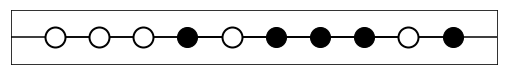

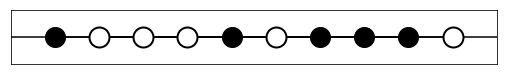

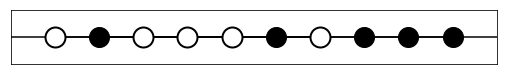

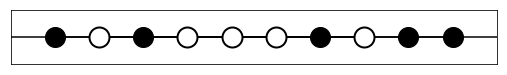

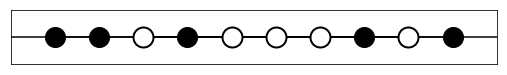

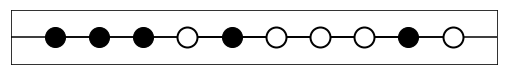

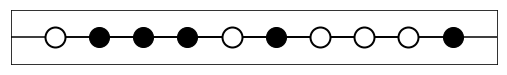

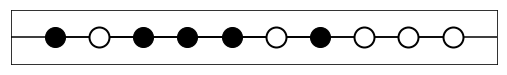

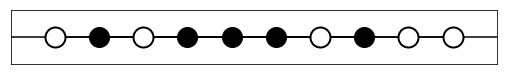

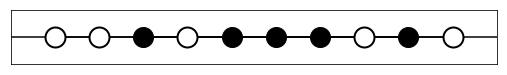

In [15]:
for i,state in enumerate(a.state_set(a.state[1])):
    plot_spin(state, test.size)

In [9]:
test.initialize('test',True)

Current system saved at "test"
Hardcore boson system
Name         : lattice8
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 8

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [50]:
preset(test)
H = Operator.Null(test)
t = 1
v = 1
t_ = 1
v_ = 1
for i in range(test.size):
    H+= -t*hopping.index(i,i+1) +v*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H+= -t_*hopping.index(i,i+2) + v_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)

In [52]:
H.set_name("H")

In [2]:
test = System(5)

In [9]:
isinstance({},object)

True

In [3]:
test.name = 'test'

In [7]:
del b

In [8]:
d = {i:i for i in range(10)}

In [64]:
d['rd'] =0

In [65]:
d['rd']

0

In [66]:
for key in d:
    print(key)

0
1
2
3
4
5
6
7
8
9
rd


In [58]:
test.get_basis(q=2,k=0).print_states(state_set= True)

Initializing momentum sectors of given basis : (2,-1,0,0)
         3 :  |00000011>, |10000001>, |11000000>, |01100000>, |00110000>, |00011000>, |00001100>, |00000110>
         5 :  |00000101>, |10000010>, |01000001>, |10100000>, |01010000>, |00101000>, |00010100>, |00001010>
         9 :  |00001001>, |10000100>, |01000010>, |00100001>, |10010000>, |01001000>, |00100100>, |00010010>
        17 :  |00010001>, |10001000>, |01000100>, |00100010>


In [53]:
H.get_eigenvalue(test.get_basis(3))

Initializing.... it may takes few minutes.


array([-9.39271169, -5.44621828, -5.44621828, -4.83290571, -4.83290571,
       -4.76243306, -4.57700633, -4.57700633, -3.66737672, -3.66737672,
       -2.9291975 , -2.9291975 , -2.38670225, -2.32259187, -2.32259187,
       -1.74720713, -1.61803399, -1.37445499, -1.37445499, -0.94275429,
       -0.94275429, -0.94222775, -0.94222775, -0.82529635, -0.72253793,
       -0.72253793, -0.43190782, -0.43190782, -0.10387657, -0.10387657,
        0.38196601,  0.40547695,  0.61803399,  1.21204259,  1.21204259,
        1.28092833,  1.3643101 ,  1.3643101 ,  1.52924092,  2.15177154,
        2.15177154,  2.45077572,  2.45077572,  2.61803399,  2.69947095,
        2.90531086,  2.90531086,  3.19923333,  3.20159924,  3.20159924,
        3.21690767,  3.21690767,  3.23475289,  3.23475289,  4.55558514,
        4.55558514])

In [54]:
test.tree

System must be initialized. please make sure your path and file with 'initialize(path)'
Hardcore boson system
Name         : lattice8
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 8

Referenced Basis :   (None means full)
	|- Sector [ 3 -1  0  0] 
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	|- H
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [44]:
np.arange(100).reshape(10,-1) @np.arange(100).reshape(10,-1) 

array([[ 2850,  2895,  2940,  2985,  3030,  3075,  3120,  3165,  3210,
         3255],
       [ 7350,  7495,  7640,  7785,  7930,  8075,  8220,  8365,  8510,
         8655],
       [11850, 12095, 12340, 12585, 12830, 13075, 13320, 13565, 13810,
        14055],
       [16350, 16695, 17040, 17385, 17730, 18075, 18420, 18765, 19110,
        19455],
       [20850, 21295, 21740, 22185, 22630, 23075, 23520, 23965, 24410,
        24855],
       [25350, 25895, 26440, 26985, 27530, 28075, 28620, 29165, 29710,
        30255],
       [29850, 30495, 31140, 31785, 32430, 33075, 33720, 34365, 35010,
        35655],
       [34350, 35095, 35840, 36585, 37330, 38075, 38820, 39565, 40310,
        41055],
       [38850, 39695, 40540, 41385, 42230, 43075, 43920, 44765, 45610,
        46455],
       [43350, 44295, 45240, 46185, 47130, 48075, 49020, 49965, 50910,
        51855]])

In [13]:
H.set_name('H')

In [14]:
test.tree

System must be initialized. please make sure your path and file with 'initialize(path)'
Hardcore boson system
Name         : lattice8
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 8

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	|- H
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [15]:
test.get_operator("H")

In [17]:
a = test.get_basis(4)
b = test.get_basis(q=4,k=0)

In [55]:
@to_operator(test)
def b_i_new(x,i):
    if x>>i&1:
        return x - (1<<i)
    else:
        return -1

In [27]:
b_i_new.index(1).acton([7])

[{5: (1+0j)}]

In [29]:
test.saver.ls(show_all=True)

test/lattice8.hdf5
	/basis : dir
		/basis/(-1,-1,0,0) : dir
		/basis/(0,-1,0,0) : dir
			address
			period
			state
		/basis/(1,-1,0,0) : dir
			address
			period
			state
		/basis/(2,-1,0,0) : dir
			address
			period
			state
		/basis/(3,-1,0,0) : dir
			address
			period
			state
		/basis/(4,-1,0,0) : dir
			/basis/(4,-1,0,0)/H : dir
				eigenvalue
				eigenvector
			address
			period
			state
		/basis/(4,0,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,1,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,2,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,3,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,4,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,5,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,6,0,0) : dir
			address
			distance
			period
			state
			state_set
		/basis/(4,7,0,0) : dir
			address
			d

In [30]:
f1 = test.saver['/basis/(4,0,0,0)']

In [33]:
d1 = f1['state'][:]

In [35]:
d1

array([15, 23, 27, 29, 39, 43, 45, 51, 53, 85])

In [36]:
f1.create_dataset('test',data = np.arange(1000, dtype = np.complex128))

<HDF5 dataset "test": shape (1000,), type "<c16">

In [25]:
test.tree

System must be initialized. please make sure your path and file with 'initialize(path)'
Hardcore boson system
Name         : lattice8
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 8

Referenced Basis :   (None means full)
	|- Sector [4 0 0 0] 
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	|- H
	|- b_i_new
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [18]:
H.get_eigenvalue(a)

Initializing.... it may takes few minutes.


array([-6.17398871e+00, -4.82842712e+00, -4.51881669e+00, -4.22491545e+00,
       -4.22491545e+00, -3.38510898e+00, -3.38510898e+00, -3.10277505e+00,
       -3.10277505e+00, -2.93185165e+00, -2.93185165e+00, -2.80752066e+00,
       -2.80752066e+00, -2.57200120e+00, -2.00000000e+00, -1.71283831e+00,
       -1.71283831e+00, -1.57103462e+00, -1.57103462e+00, -1.51763809e+00,
       -1.51763809e+00, -1.39069927e+00, -1.14636549e+00, -1.14636549e+00,
       -1.11938890e+00, -1.11938890e+00, -1.00000000e+00, -1.00000000e+00,
       -4.82361910e-01, -4.82361910e-01, -4.16020848e-01, -4.14213562e-01,
       -4.14213562e-01, -4.14213562e-01, -4.14213562e-01, -1.55431340e-01,
       -1.55431340e-01, -3.34581151e-16, -2.83248411e-16, -2.81624990e-16,
        5.60107372e-16,  3.24404881e-01,  3.24404881e-01,  4.93936040e-01,
        8.28427125e-01,  9.31851653e-01,  9.31851653e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.21752516e+00,
        1.21752516e+00,  

In [21]:
b.print_states(state_set=True)

        15 :  |00001111>, |10000111>, |11000011>, |11100001>, |11110000>, |01111000>, |00111100>, |00011110>
        23 :  |00010111>, |10001011>, |11000101>, |11100010>, |01110001>, |10111000>, |01011100>, |00101110>
        27 :  |00011011>, |10001101>, |11000110>, |01100011>, |10110001>, |11011000>, |01101100>, |00110110>
        29 :  |00011101>, |10001110>, |01000111>, |10100011>, |11010001>, |11101000>, |01110100>, |00111010>
        39 :  |00100111>, |10010011>, |11001001>, |11100100>, |01110010>, |00111001>, |10011100>, |01001110>
        43 :  |00101011>, |10010101>, |11001010>, |01100101>, |10110010>, |01011001>, |10101100>, |01010110>
        45 :  |00101101>, |10010110>, |01001011>, |10100101>, |11010010>, |01101001>, |10110100>, |01011010>
        51 :  |00110011>, |10011001>, |11001100>, |01100110>
        53 :  |00110101>, |10011010>, |01001101>, |10100110>, |01010011>, |10101001>, |11010100>, |01101010>
        85 :  |01010101>, |10101010>


In [571]:
a=  test.get_basis(4)
a.period(np.arange(len(a)))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [370]:
basis.print_states()

        15 :  00001111
        45 :  00101101
        51 :  00110011
        85 :  01010101
        23 :  00010111
        27 :  00011011
        43 :  00101011


In [373]:
preset(test)

In [376]:
H.set_name('H')

In [431]:
energy=H.get_eigenvalue(test.get_basis(4,0))

Initializing.... it may takes few minutes.


In [438]:
e_set = H.get_eigenvalue(test.get_basis(q=4,k=0,f=1))

In [439]:
e_set

array([-5.12849407, -2.35348197, -0.72415255, -0.40255777,  0.33909421,
        2.14800257,  3.12158959])

# Dev

### Workspace

In [9]:
class Variable(object):
    def __init__(self):
        self.name  = self.get_self_name()
    @property
    def tree(self):
        return 
    @tree.getter
    def tree(self):
        return self.__dict__
    def __getitem__(self, key):
        return self.__dict__[key]
    @classmethod
    def get_variables(cls):
        glob = globals()
        for i in glob:
            if isinstance(glob[i],cls):
                yield i,glob[i]
    
    def get_locals(self):
        return vars(self)
    def get_self_name(self):
        for name in globals():
            if globals()[name] == self:
                return name

### Saver

$$n(k)= \frac{1}{L}\sum_{i,j}{e^{k(i-j)}b^\dagger_ib_j}$$

$$N(k)= \frac{1}{L}\sum_{i,j}{e^{k(i-j)}n_in_j}$$

In [9]:
test_system = System(20)

In [10]:
preset(test_system)

NameError: name 'preset' is not defined

In [15]:
test_system.saver.file

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [10]:
test_system.initialize('test',True)

Current system saved at "test/"
Hardcore boson system
Name         : lattice20
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 20

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [11]:
basis = test_system.get_basis(q=10,k=0)

Initializing spin conserving sectors of given basis : (-1,-1,0,0)
Initializing momentum sectors of given basis : (10,-1,0,0)


In [213]:
basis

<Basis sector of lattice size 20 with symmetry factor(Q,K,F,P) = (3,-1,0,0)>

In [203]:
H = Operator.Null(test_system)
for i in range(test_system.size):
    H += n_i.index(i)

In [204]:
H.set_name('H')

In [207]:
test_system.save()

In [208]:
Operator.load(test_system,'H')

In [148]:
H._label

'N00+N01+N02+N03+N04'

In [152]:
test_system.set_path('.')

In [153]:
test_system.initialize('test',force=True)

Current system saved at "test/"
Hardcore boson system
Name         : lattice5
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 5

Referenced Basis :   (None means full)
	|- Sector [-1 -1  0  0] 
	-----

Defined Operators :
	-----
	Hamiltonian  : -----

Defined States :
	-----



In [130]:
a = test_system.get_basis(q = 2,k=2)

Initializing spin conserving sectors of given basis : (-1,-1,0,0)
Initializing momentum sectors of given basis : (2,-1,0,0)


In [131]:
a = test_system.get_basis(q = 2,k=3)

In [113]:
a.print_states()

         1 :00001


In [16]:
import xxzchain

In [19]:
a = xxzchain.System(5)

In [21]:
a.initialize('test')

Current system saved at "test/"
Hardcore boson system
Name         : lattice5
Saved path   : /Users/jeong/master/xxzchain/test
System size  : 5

Basis sector : Full Sector
Referenced Basis :   (None means full)
	-----

Defined Operators :
	-----
Hamiltonian  : -----

Defined States :
	-----



In [23]:
b= a.get_basis(4,1)

In [25]:
b.print_states(True)

         0 :00000
         1 :00001
         2 :00010
         3 :00011
         4 :00100
         5 :00101
         6 :00110
         7 :00111
         8 :01000
         9 :01001
        10 :01010
        11 :01011
        12 :01100
        13 :01101
        14 :01110
        15 :01111
        16 :10000
        17 :10001
        18 :10010
        19 :10011
        20 :10100
        21 :10101
        22 :10110
        23 :10111
        24 :11000
        25 :11001
        26 :11010
        27 :11011
        28 :11100
        29 :11101
        30 :11110
        31 :11111


In [14]:
a.saver.ls(show_all=True)

./lattice5.hdf5
	/basis : dir
		/basis/(0,-1,0,0) : dir
			address
			period
			state
		/basis/(1,-1,0,0) : dir
			address
			period
			state
		/basis/(2,-1,0,0) : dir
			address
			period
			state
		/basis/(3,-1,0,0) : dir
			address
			period
			state
		/basis/(4,-1,0,0) : dir
			address
			period
			state
		/basis/(4,0,0,0) : dir
			address
			distance
			period
			state
		/basis/(4,1,0,0) : dir
			address
			distance
			period
			state
		/basis/(4,2,0,0) : dir
			address
			distance
			period
			state
		/basis/(4,3,0,0) : dir
			address
			distance
			period
			state
		/basis/(4,4,0,0) : dir
			address
			distance
			period
			state


In [229]:
b= a.initializer.K(a.get_basis(q=2))

In [71]:
list(a.saver.attrs.items())

[('H', b'Null'), ('name', b'lattice5'), ('size', 5)]

In [10]:
b=  h5py.File('test/lattice5.hdf5','w')

In [11]:
b.close()

In [32]:
del a

### Initializer

***

In [10]:
import xxzchain as xxz

test.system = xxz.System(5)
xxz.preset(test.system)

test.H =Operator.Null()
for i in range(test.system.size):
    test.H = 

In [11]:
n_i

In [531]:
test = System(10,method='K')
preset(test)
test.initialize('test',force =True)
basis = test.get_basis(5,0)

Current system saved at "test"
Hardcore boson system
Name         : lattice10
Saved path   : C:\Users\jeong\master\xxzchain\test\
System size  : 10

Basis sector : Particle number conserved(Q) with total Momentum(K) sector
Referenced Basis :   (None means full)
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	-----
Hamiltonian  : -----

Defined States :
	-----



In [358]:
n = {}
for k in range(test.size):
    n[k] = Operator.Null(test)
    for i in range(test.size):
        for j in range(test.size):
            n[k] += 1/test.size*np.exp(-2j*np.pi/test.size*k*(i-j))*b_i_dag.index(i)@b_i.index(j)

In [359]:
N = {}
for k in range(test.size):
    N[k] = Operator.Null(test)
    for i in range(test.size):
        for j in range(test.size):
            N[k] += 1/test.size*np.exp(-2j*np.pi/test.size*k*(i-j))*n_i.index(i)@n_i.index(j)

In [252]:
N[4].coef

array([ 0.2      +0.j        ,  0.0618034-0.1902113j ,
       -0.1618034-0.11755705j, -0.1618034+0.11755705j,
        0.0618034+0.1902113j ,  0.0618034+0.1902113j ,
        0.2      +0.j        ,  0.0618034-0.1902113j ,
       -0.1618034-0.11755705j, -0.1618034+0.11755705j,
       -0.1618034+0.11755705j,  0.0618034+0.1902113j ,
        0.2      +0.j        ,  0.0618034-0.1902113j ,
       -0.1618034-0.11755705j, -0.1618034-0.11755705j,
       -0.1618034+0.11755705j,  0.0618034+0.1902113j ,
        0.2      +0.j        ,  0.0618034-0.1902113j ,
        0.0618034-0.1902113j , -0.1618034-0.11755705j,
       -0.1618034+0.11755705j,  0.0618034+0.1902113j ,
        0.2      +0.j        ])

In [253]:
a = b_i_dag.index(1)@b_i.index(2)

In [360]:
for k in n:
    n[k].set_name('momentum ({}*pi)'.format(2*k/test.size if k*2<test.size else -2*(test.size-k)/test.size))

In [307]:
n[3].name

'momentum (0.2857142857142857*pi)'

In [361]:
test.tree

Hardcore boson system
Name         : lattice10
Saved path   : C:\Users\jeong\master\xxzchain\test\
System size  : 10

Basis sector : Particle number conserved(Q) with total Momentum(K) sector
Referenced Basis :   (None means full)
	|- Sector (5, 0) 
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	|- momentum (0.0*pi)
	|- momentum (0.2*pi)
	|- momentum (0.4*pi)
	|- momentum (0.6*pi)
	|- momentum (0.8*pi)
	|- momentum (-1.0*pi)
	|- momentum (-0.8*pi)
	|- momentum (-0.6*pi)
	|- momentum (-0.4*pi)
	|- momentum (-0.2*pi)
	-----
Hamiltonian  : -----

Defined States :
	-----



In [362]:
H_ini = Operator.Null(test)
t = 2.0
V = 1.0
t_= 1.0
V_ = 1.0
for i in range(test.size):
    H_ini+= -t*hopping.index(i,i+1)+V*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H_ini+= -t_*hopping.index(i,i+2)+V_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)

In [363]:
H_fin = Operator.Null(test)
t = 1.0
V = 1.0
t_= 1.0
V_ = 1.0
for i in range(test.size):
    H_fin+= -t*hopping.index(i,i+1)+V*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H_fin+= -t_*hopping.index(i,i+2)+V_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)

In [364]:
H_fin.set_name('H_fin')

In [365]:
H_ini.set_name('H_ini')

In [366]:
def partition(H):
    global T
    return np.exp(-H/T)

In [367]:
sevens = [test.get_basis(5,i) for i in range(test.size)]

In [353]:
sevens[0].period(4567112)

array(-1)

In [610]:
test = System(5,method='K')
preset(test)
test.initialize('test',force =True)
basis = test.get_basis(2,0)

Current system saved at "test"
Hardcore boson system
Name         : lattice5
Saved path   : C:\Users\jeong\master\xxzchain\test\
System size  : 5

Basis sector : Particle number conserved(Q) with total Momentum(K) sector
Referenced Basis :   (None means full)
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	-----
Hamiltonian  : -----

Defined States :
	-----



In [611]:
H_ini = Operator.Null(test)
t = 2.0
V = 1.0
t_= 1.0
V_ = 1.0
for i in range(test.size):
    H_ini+= -t*hopping.index(i,i+1)+V*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H_ini+= -t_*hopping.index(i,i+2)+V_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)
H_ini.set_name("H_ini")

In [511]:
a = test.get_basis(3,0)

In [593]:
test.get_basis(3,0).print_states(True)

         7 :000111
        11 :001011
        13 :001101
        21 :010101


In [513]:
a._finit()

In [514]:
H_ini.acton(a.state)[0]

{-1: (-10+0j),
 7: (0.5+0j),
 13: (-1+0j),
 11: (-2+0j),
 19: (-1+0j),
 38: (-1+0j),
 70: (-2+0j),
 69: (-1+0j)}

In [515]:
for i, result in enumerate(H_ini.acton(a.state)):
    origin = np.array([i for i in result if i>0])
    print(a.convert(origin))

[0 2 1 3 3 2 1]
[1 0 2 0 3 2 4 4 3]
[0 2 1 0 3 4 4 1 3]
[3 1 4 3 0 1 2 0 3 4 2]
[1 4 3 3 2 4 1 2 4]


In [516]:
a.convert()

TypeError: _convert() missing 1 required positional argument: 'state'

In [517]:
a.print_states(True)

         7 :0000111
        11 :0001011
        13 :0001101
        19 :0010011
        21 :0010101


In [525]:
a.period(4)

array(7)

In [527]:
len(H_ini.acton(a.state))

5

In [530]:
for i, result in enumerate(H_ini.acton(a.state)):
    origin = np.array([st for st in result if st>0])
    print(a.convert(origin))
    value = np.array([result[st] for st in result if not st<0])
    target = a.convert(origin)
    dist = a.distance(origin)
    print(dist)
    period = a.period(target)
    print(period)
    operiod =  a.period(i)
    print(operiod)
    angle  = a.K * dist/test.size
    matrix[target*matsize + i] += value*np.sqrt(period/basis.period(states[i]))*np.exp(angle*1j)

[0 2 1 3 3 2 1]
[0 0 0 0 6 1 1]
[7 7 7 7 7 7 7]
7
[1 0 2 0 3 2 4 4 3]
[0 6 0 0 0 2 6 1 1]
[7 7 7 7 7 7 7 7 7]
7
[0 2 1 0 3 4 4 1 3]
[6 0 0 0 4 0 2 5 5]
[7 7 7 7 7 7 7 7 7]
7
[3 1 4 3 0 1 2 0 3 4 2]
[0 6 0 4 0 0 2 1 3 3 3]
[7 7 7 7 7 7 7 7 7 7 7]
7
[1 4 3 3 2 4 1 2 4]
[6 0 0 4 0 2 1 5 5]
[7 7 7 7 7 7 7 7 7]
7


'''return matrix form of Operator as given basis'''
        if self.__initial == (basis.Q, basis.K):
            if  not self.matrix is None: return self.matrix
        ############################# load must be implemented
        if self.system.get_method ==2:
            basis._finit()
        states = basis.state
        matsize = len(states)
        dtype = self.system.Odtype
        K = False
        if not (basis.K is None):
            K = True
        matrix = np.zeros([matsize**2],dtype = dtype)
        
        self.__initial = (basis.Q,basis.K)
        for i, result in enumerate(self.acton(states)):
            
            origin = np.array([st for st in result if not st<0])
            if len(origin)== 0 : continue
            
            value = np.array([result[st] for st in result if not st<0])
            target = basis.convert(origin)
            if K:
                dist = basis.distance(origin)
                period = basis.period(target)
                angle  = basis.K * dist/self.system.size
                matrix[target*matsize + i] += value*np.sqrt(period/basis.period(states[i]))*np.exp(angle*1j)
            else:
                matrix[target*matsize + i] += value
                
        if not K:
            matrix = matrix.real
        self.matrix = matrix.reshape(matsize,matsize)
        return self.matrix

In [544]:
a = [i for i in H_ini.acton(test.get_basis(7,0).state)[0] if i>=0]

In [549]:
test.get_basis(7,0).convert(a)*12+0

array([ 0, 24, 12, 72, 12, 72, 60])

In [653]:
test = System(15,method='K')
preset(test)
test.initialize('test',force =True)
basis = test.get_basis(2,0)

Current system saved at "test"
Hardcore boson system
Name         : lattice15
Saved path   : C:\Users\jeong\master\xxzchain\test\
System size  : 15

Basis sector : Particle number conserved(Q) with total Momentum(K) sector
Referenced Basis :   (None means full)
	-----

Defined Operators :
	|- n_i
	|- b_i
	|- b_i_dag
	|- hopping
	-----
Hamiltonian  : -----

Defined States :
	-----



In [654]:
H_ini = Operator.Null(test)
t = 0.5
V = 2.0
t_= 0.24
V_ = 0.24
for i in range(test.size):
    H_ini+= -t*hopping.index(i,i+1)+V*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H_ini+= -t_*hopping.index(i,i+2)+V_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)
H_ini.set_name("H_ini")

In [655]:
H_fin = Operator.Null(test)
t = 1.0
V = 1.0
t_= 0.24
V_ = 0.24
for i in range(test.size):
    H_fin += -t*hopping.index(i,i+1)+V*(n_i.index(i)-1/2)@(n_i.index(i+1)-1/2)
    H_fin += -t_*hopping.index(i,i+2)+V_*(n_i.index(i)-1/2)@(n_i.index(i+2)-1/2)
H_fin.set_name("H_fin")

In [656]:
for i in range(test.size):
    H_ini.get_eigenvalue(test.get_basis(5,i))

Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.


In [658]:
for i in range(test.size):
    H_fin.get_eigenvalue(test.get_basis(5,i))

Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.
Initializing.... it may takes few minutes.


In [657]:
ini_state = H_ini.get_eigenstates(test.get_basis(5,0))

In [659]:
H_fin.expectation(ini_state)

array([-9.85049949e+00+0.j, -7.29091702e+00+0.j, -4.94244790e+00+0.j,
       -5.44218248e+00+0.j, -5.91792172e+00+0.j, -4.47997876e+00+0.j,
       -4.70550086e+00+0.j, -3.58527413e+00+0.j, -3.73812126e+00+0.j,
       -4.03265812e+00+0.j, -4.11360749e+00+0.j, -4.08824754e+00+0.j,
       -4.04794993e+00+0.j, -4.12047009e+00+0.j, -3.49277961e+00+0.j,
       -4.13524380e+00+0.j, -3.16888469e+00+0.j, -2.64833260e+00+0.j,
       -2.60029238e+00+0.j, -2.39852464e+00+0.j, -2.79381617e+00+0.j,
       -2.23797799e+00+0.j, -3.62556930e+00+0.j, -2.22977822e+00+0.j,
       -3.14123115e+00+0.j, -3.31637649e+00+0.j, -2.27714169e+00+0.j,
       -3.28745889e+00+0.j, -3.12919653e+00+0.j, -3.46196337e+00+0.j,
       -2.38782311e+00+0.j, -2.06324371e+00+0.j, -3.00742753e+00+0.j,
       -2.47298389e+00+0.j, -2.63887555e+00+0.j, -2.46332652e+00+0.j,
       -2.26797281e+00+0.j, -2.56902257e+00+0.j, -2.15105130e+00+0.j,
       -1.87827302e+00+0.j, -2.11584700e+00+0.j, -2.31265146e+00+0.j,
       -1.10031695e+

In [279]:
T = 1.0
Z = H_ini.trace([test.get_basis()],func=partition)

In [667]:
def partition_f(H,T):
        
    return np.exp(-H/T)

def temper(func, T):
    def wrapper(x):
        return func(x,T)
    return wrapper

In [670]:
T_set = np.arange(1000)*0.02+0.1

E_set = []
for T in T_set:
    partition = temper(partition_f,T)
    Z = H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=partition)
    E_set.append(H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=lambda H: H*np.exp(-H/T)/Z))

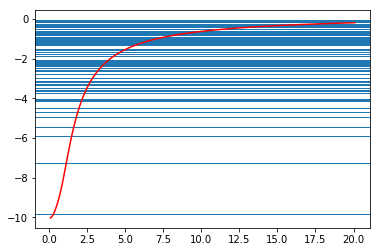

In [673]:
plt.figure()
for v in H_fin.expectation(ini_state).real[H_fin.expectation(ini_state).real<0]:
    plt.axhline(y=v, linewidth = 1)

plt.plot(T_set,E_set,'r')
plt.savefig('E-effT.png')

In [674]:
T_set1 = np.arange(200)*0.002+0.1

E_set1 = []
for T in T_set1:
    partition = temper(partition_f,T)
    Z = H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=partition)
    E_set1.append(H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=lambda H: H*np.exp(-H/T)/Z))

In [688]:
H_fin.expectation(ini_state).real[np.logical_and(H_fin.expectation(ini_state).real<E_set[95]+0.2,H_fin.expectation(ini_state).real>E_set[95]-0.2)]

array([-4.47997876])

In [708]:
np.logical_and(H_fin.expectation(ini_state).real<E_set[95]+0.2,H_fin.expectation(ini_state).real>E_set[95]-0.2)

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [697]:
i = 9
T_set[i],E_set[i]

(1.9800000000000002, -4.491728247295916)

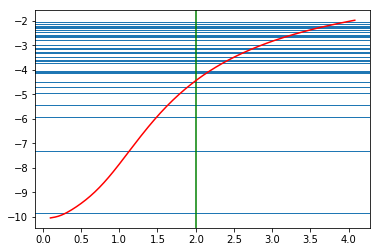

In [681]:
plt.figure()
for v in H_fin.expectation(ini_state).real[H_fin.expectation(ini_state).real<-2]:
    plt.axhline(y=v, linewidth = 1)
plt.axvline(x=2.0,c='g')
plt.plot(T_set1,E_set1,'r')
plt.savefig('E-effT4.png')

In [712]:
target = ini_state.coef.T[5].T

In [714]:
n = {}
for k in range(test.size):
    n[k] = Operator.Null(test)
    for i in range(test.size):
        for j in range(test.size):
            n[k] += 1/test.size*np.exp(-2j*np.pi/test.size*k*(i-j))*b_i_dag.index(i)@b_i.index(j)

In [715]:
N = {}
for k in range(test.size):
    N[k] = Operator.Null(test)
    for i in range(test.size):
        for j in range(test.size):
            N[k] += 1/test.size*np.exp(-2j*np.pi/test.size*k*(i-j))*n_i.index(i)@n_i.index(j)

In [721]:
target = State(test.get_basis(5,0),target)

In [729]:
target.coef.shape

(201,)

In [732]:
n[0].get_matrix(test.get_basis(5,0)).shape

(201, 201)

In [739]:
n_k = []
for k in n:
    n[k].get_matrix(test.get_basis(5,0))
    n_k.append(target.coef.T@n[k].get_matrix(test.get_basis(5,0))@target.coef)

In [755]:
K = []
for k in n:
    K.append(k/test.size*2*np.pi  if k/test.size < 1/2 else -2*np.pi*(1-k/test.size))

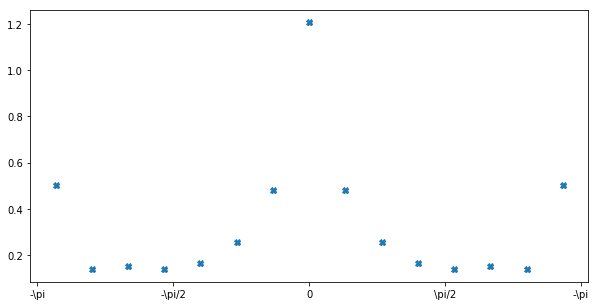

In [774]:
plt.figure(figsize = [10,5])
plt.plot(K,n_k,'X')
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-\pi',r'-\pi/2',0,r'\pi/2',r'-\pi'])
plt.savefig("nk.png")

In [761]:
N_k=[]
for k in N:
    N[k].get_matrix(test.get_basis(5,0))
    N_k.append((target.coef.T@N[k].get_matrix(test.get_basis(5,0))@target.coef).real)

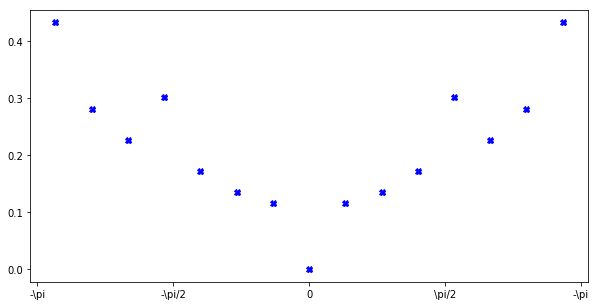

In [773]:
plt.figure(figsize = [10,5])
plt.plot(K[1:],N_k[1:],'bX')
plt.plot([0],[0],'bX')
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],[r'-\pi',r'-\pi/2',0,r'\pi/2',r'-\pi'])
plt.savefig('largeNk.png')

In [701]:
T_set2 = np.arange(200)*0.01+0.1

E_set2 = []
for T in T_set2:
    partition = temper(partition_f,T)
    Z = H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=partition)
    E_set.append(H_fin.trace([test.get_basis(5,i) for i in range(test.size)],func=lambda H: H*np.exp(-H/T)/Z))

In [702]:
H_fin.expectation(ini_state).real[np.logical_and(H_fin.expectation(ini_state).real<E_set[95]+0.2,H_fin.expectation(ini_state).real>E_set[95]-0.2)]

array([-4.47997876])

In [707]:
i = 189
T_set2[i],E_set2[i]

(1.9900000000000002, -4.468079174817852)

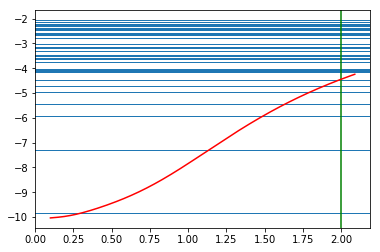

In [704]:
plt.figure()
for v in H_fin.expectation(ini_state).real[H_fin.expectation(ini_state).real<-2]:
    plt.axhline(y=v, linewidth = 1)
plt.axvline(x=2.0,c='g')
plt.plot(T_set2,E_set2,'r')
plt.savefig('E-effT8.png')

In [281]:
H_ini.trace(test.get_basis(),func=lambda H: H*np.exp(-H/T)/Z)

-2.7470258227989075

In [182]:
Operator.__dict__

mappingproxy({'__module__': '__main__',
              '__init__': <function __main__.Operator.__init__(self, system, name=None, prefix=None)>,
              'Null': <function __main__.Operator.Null(system)>,
              'loadlabel': <function __main__.Operator.loadlabel(system, label)>,
              'save': <function __main__.Operator.save(self, path=None, force=False)>,
              'load': <function __main__.Operator.load(system, name)>,
              'set_default': <function __main__.Operator.set_default(self, bool)>,
              'is_identity': <function __main__.Operator.is_identity(self)>,
              'valid': <function __main__.Operator.valid(self)>,
              '_set_name': <function __main__.Operator._set_name(self, name)>,
              'set_name': <function __main__.Operator.set_name(self, name)>,
              'get_matrix': <function __main__.Operator.get_matrix(self, basis)>,
              'trace': <function __main__.Operator.trace(self, basis_set, func=<function 

In [65]:
class Variable:
    def pp(self):
        print(locals())
    def vas(self):
        print(vars())
    def definer(self,name,  value):
        globals()[name] = value

In [34]:
a.i = 1

In [38]:
vars()[a.i]

KeyError: 1

In [66]:
a = Variable()

In [67]:
a.definer('something',1)

In [63]:
a.something

AttributeError: 'Variable' object has no attribute 'something'

In [68]:
something

1

In [42]:
a.i = 1

In [54]:
a.__dict__

{'i': 1}

In [57]:
vars(a)['a'] = 10

In [58]:
a.a

10

In [35]:
a.pp()

{'self': <__main__.Variable object at 0x0000027ED9643CF8>}


In [20]:
H_ini.__dict__

{'system': <__main__.System at 0x27ed9264080>,
 'size': 5,
 'name': 'H_ini',
 '_Operator__default': False,
 '_label': 'H0001+N00@N01+N00@I+I@N01+I@I+H0002+N00@N02+N00@I+I@N02+I@I+H0102+N01@N02+N01@I+I@N02+I@I+H0103+N01@N03+N01@I+I@N03+I@I+H0203+N02@N03+N02@I+I@N03+I@I+H0204+N02@N04+N02@I+I@N04+I@I+H0304+N03@N04+N03@I+I@N04+I@I+H0300+N03@N00+N03@I+I@N00+I@I+H0400+N04@N00+N04@I+I@N00+I@I+H0401+N04@N01+N04@I+I@N01+I@I',
 'struct': [<function __main__.Operator.index.<locals>.<lambda>(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function __main__.Operator.index.<locals>.<lambda>(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function __main__.Operator.__matmul__.<locals>.dec.<locals>.wrap(x)>,
  <function _

In [ ]:
eigenvalue = 

In [ ]:
def partition(T):
    
    

In [165]:
H.get_matrix(test.get_basis())[np.diag_indices(32)].sum()

0.0

In [775]:
a = None
b = None


True